In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorcet as cc
sns.set(style="white", rc={"figure.figsize":(8, 4)})
plt.style.use('ggplot') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn import feature_extraction
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from scipy.spatial.distance import pdist, cdist

from kneed import KneeLocator
# import re
# import nltk
# # nltk.download('stopwords') # required to be downloaded only for the first time
# # nltk.download('wordnet') # required to be downloaded only for the first time
# # nltk.download('omw-1.4') # required to be downloaded only for the first time
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# from wordcloud import WordCloud
import itertools

from scipy import stats
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
import heapq
import operator

import warnings
warnings.filterwarnings("ignore")

---

#### 1. Fetch price data

In [2]:
stocks_hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
stocks_hist_price_df.date = pd.to_datetime(stocks_hist_price_df.date, format='ISO8601')
# stocks_hist_price_df.head()

# fetch the historical adj close price
hist_close_df = stocks_hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')
hist_close_df.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BF-B,BG,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRK-B,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CEG,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FICO,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEHC,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OGN,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,PODD,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBUX,SCHW,SEDG,SEE,SHW,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.457943,4.496162,37.147512,6.496297,NaN,21.839928,19.471235,7.994436,32.875025,37.09,22.997974,22.409246,27.363355,25.67,16.766800,20.912558,10.024065,17.154249,20.235688,23.103710,15.358914,25.92,31.517963,18.50,7.842692,22.636278,NaN,11.307991,NaN,9.70,15.740881,42.912508,29.673734,35.160463,6.6950,NaN,44.64,32.784855,6.147614,86.618664,59.712849,10.264374,NaN,42.776729,19.981378,10.019500,53.049670,13.992153,27.311765,16.701765,33.579803,158.03,43.712259,13.086236,11.668706,25.019825,7.497274,27.064023,61.341946,23.011332,10.800925,47.214855,53.64,97.87,21.234672,223.96,NaN,167.966113,16.695592,17.081904,66.220,7.713207,9.01,14.683823,42.933663,27.825769,11.912359,22.675749,NaN,41.171252,32.283174,NaN,13.82,28.536110,23.891690,NaN,6.12,NaN,26.848754,NaN,13.748092,NaN,12.566431,44.269090,NaN,34.795569,16.727843,30.313062,41.974803,21.786500,6.532045,40.555159,87.84,34.259811,10.119533,5.4250,8.614518,32.143401,37.511240,24.977002,43.857640,22.698190,4.55125,25.028694,33.57,18.7050,17.274800,4.225,4.290561,21.672964,NaN,9.200037,21.694960,NaN,25.073893,46.843021,NaN,22.916943,9.968644,48.512039,42.954680,11.571938,21.251224,48.166555,9.600871,27.202972,27.936839,19.043274,29.164191,16.056675,21.874222,NaN,7.196076,20.479561,22.937698,28.225121,29.960,53.533087,NaN,2.1400,17.902883,9.559508,38.792110,26.727375,26.887459,21.994975,20.063036,49.839040,21.9061

---

### 2. cluster data

In [3]:
cluster_df = pd.read_csv('../data/db_clabel_10y_data.csv')
target_cluster_df = cluster_df[cluster_df.cluster!=-1].reset_index(drop=True)
target_cluster_df.head()

,ticker,company_name,sector,cluster,bus_desc,Quick ratio,Cash ratio,Interest coverage,Debt equity ratio,Asset turnover,Receivables turnover,Return on assets,Operating profit margin,Enterprise value multiple,Payout ratio
0,ABBV,AbbVie,Health Care,3,AbbVie is an American publicly traded biopharm...,1.4990,0.97925,15.32825,5.750625,0.524125,5.102375,0.10575,0.301125,15.975625,0.74325
1,ABC,AmerisourceBergen,Health Care,2,AmerisourceBergen Corporation is an American d...,0.4915,0.11150,0.00000,12.862101,4.874700,17.167100,0.02870,0.009700,13.700800,0.15160
2,ADM,ADM,Consumer Staples,2,"The Archer-Daniels-Midland Company, commonly k...",0.5166,0.09360,0.00000,1.229600,1.772900,15.331700,0.04130,0.029300,8.803700,0.37790
3,ADSK,Autodesk,Information Technology,0,"Autodesk, Inc. is an American multinational so...",1.6525,1.02190,0.00000,-2.708600,0.554900,5.185900,-0.00240,0.013900,47.191400,0.00000
4,AES,AES Corporation,Utilities,4,The AES Corporation is a Fortune 500 company t...,0.6614,0.22450,2.04690,8.309500,0.379200,6.661600,-0.00100,0.196400,10.367000,0.30510


In [4]:
# ordered cluster labels and counts
ordered_clabel_counts_series = target_cluster_df.cluster.value_counts().sort_index()

---

### 3. Find pairs

In [5]:
training_start_date = dt.datetime(2015, 1, 1)
training_end_date = dt.datetime(2019, 12, 31)
backtest_start_date = dt.datetime(2020, 1, 1)
backtest_end_date = dt.datetime(2023, 3, 31)

look_back_days = 100 
significance = 0.05
band_width = 1.5
stoploss = 0.2
rolling_days = 50 # test phase (no trades are made)
capital_per_pair = 1000000

In [6]:
'identify cointegrated pairs from clusters'
def Cointegration(tickers: list, significance, start_day, end_day):
    coint_pairs = []
    p_value = []
    adf = []
    for i in range(len(tickers)):
        for j in range(i+1,len(tickers)):
            if ((not hist_close_df.loc[start_day:end_day, tickers[i]].isna().any()) and 
                (not hist_close_df.loc[start_day:end_day, tickers[j]].isna().any())):
                asset_1 = hist_close_df.loc[start_day:end_day, tickers[i]].values
                asset_2 = hist_close_df.loc[start_day:end_day, tickers[j]].values
                ols_fit = sm.OLS(asset_1, asset_2).fit()
                preds = ols_fit.predict(asset_2)
                error = np.subtract(asset_1, preds)
                ADFtest = ts.adfuller(error)
                if ADFtest[1] < significance:
                    coint_pairs.append([tickers[i], tickers[j]])  # pair names
                    p_value.append(ADFtest[1])  # p value, smaller the better
                    adf.append(ADFtest[0])  # adf test stats, larger the better
    return coint_pairs, p_value, adf


"Pair selection method"
"select a pair with lowest p-value from each cluster"
def PairSelection(cluster_df: pd.DataFrame, significance=significance, 
                    start_day=training_start_date, end_day=training_end_date):
    stock_pairs = []   
    tstats = []
    cluster_labels = cluster_df.cluster.value_counts().index.to_list()
    for i in range(len(cluster_labels)):
        # loop over clusters to get best coint pair in each cluster
        tickers = target_cluster_df[target_cluster_df.cluster == cluster_labels[i]]['ticker'].values
        coint_pairs, p_value, adf_values = Cointegration(tickers, significance, start_day, end_day)
        if len(coint_pairs) > 0:
            if np.min(p_value) < significance:
                index = np.where(p_value == np.min(p_value))[0][0]
                stock_pairs.append([coint_pairs[index][0], coint_pairs[index][1]])
                tstats.append(round(adf_values[index], 4))
    return stock_pairs, tstats

#### preview of pairs (we're only considering the approach of picking just one pair with the lowest p_value from each cluster)

In [7]:
stock_pairs, tstats = PairSelection(cluster_df=target_cluster_df, significance=significance, start_day=training_start_date, 
                          end_day=training_end_date)
print(f"Number of clusters: {len(ordered_clabel_counts_series)}")
print(f"Number of cointegrated pairs: {len(stock_pairs)}")
print(f"Pairs with lowest p-value from each clusters:\n{stock_pairs}")
print(f'Tstats for pairs with lowest p-value from each clusters:\n{tstats}')

Number of clusters: 11
Number of cointegrated pairs: 6
Pairs with lowest p-value from each clusters:
[['ADSK', 'IDXX'], ['CE', 'ICE'], ['HON', 'WAT'], ['ABC', 'WAB'], ['ESS', 'UDR'], ['RF', 'ZION']]
Tstats for pairs with lowest p-value from each clusters:
[-3.0775, -3.2603, -3.403, -2.9859, -2.8785, -3.6851]


In [200]:
# plot price movements for paired stocks
def plot_stock_pairs(pairs_list: stock_pairs, start_date: training_start_date, end_date: training_end_date):
    """
    Plot price charts for all the cointegrated pairs
    """
    # this code needs to be replaced with code to fetch from db
    hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
    hist_price_df.date = pd.to_datetime(hist_price_df.date, format='ISO8601')
    temp_df = hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')
    # plot a handful of the smallest clusters
    plt.figure(figsize=(10, 32))
    plt.subplots_adjust(hspace=.3, wspace=.25)
    plt.clf()
    i=1
    for pair in pairs_list:
        means = np.log(temp_df.loc[start_date:end_date, pair].mean())
        data = np.log(temp_df.loc[start_date:end_date, pair]).sub(means)
        clus = target_cluster_df[target_cluster_df.ticker == pair[0]]['cluster'].values[0]
        # max number of plots will be the number of clusters since we're only plotting one pair per cluster
        plt.subplot(ordered_clabel_counts_series.shape[0], 1, i) 
        plt.plot(temp_df.loc[start_date:end_date, pair].index, data)
        plt.title(f'Time series of log returns for the stock pair from cluster {clus}\n', weight='bold', fontsize=14)
        plt.xlabel('Date', weight='bold', fontsize=12)
        plt.ylabel('Log returns', weight='bold', fontsize=12)
        tkr_names = [f'{tkr} - {target_cluster_df[target_cluster_df.ticker == tkr].company_name.values[0]}' for tkr in pair]
        plt.legend(tkr_names)
        i+=1
    plt.tight_layout(pad=2.0)
    plt.show()

---

### 4. Portfolio creation and backtesting

In [182]:
'define moving average and rolling std of data series with time period t' 
def MVaverage(a, t):
    # a is an array of a vector of data 
    # t is the look back period (window size)

    i = np.size(a) # size of the array (total count of price observations)
    j=0
    mv_t = np.zeros(i-t+1) # placeholder for moving averages of data series with look back period t 
    std_t = np.zeros(i-t+1) # placeholder for std of data series with look back period t
    while i>(t-1):
        mv_t[j] = np.mean(a[j:(j+t)])
        std_t[j] = np.std(a[j:(j+t)])
        j += 1
        i -= 1
    return mv_t, std_t


'define bollinger band function to calculate Bollinger band width' 
def BBand(a, t, const):
    # a is an array of a vector of data
    # t is the look back period (window size)
    # const is the value we would like to set for the number of std away from the moving average

    BollingerBand = []
    mv, std = MVaverage(a, t)
    # define the lower and upper bands within which to trade
    LowerBand = np.subtract(mv, const*std)
    UpperBand = np.add(mv, const*std) 
    BollingerBand.append([LowerBand, UpperBand])
    return mv, BollingerBand


'define function to calculate maximum drawdown' 
def MaxDrawdown(cum_ret):
    # cum_ret also can be portfolio position series

    ContVal = np.zeros(np.size(cum_ret)) # placeholder for storing the diff of max recorded cum ret value & current cum ret value
    MaxDD = np.zeros(np.size(cum_ret)) 
    for i in range(np.size(cum_ret)):
        # loop through the length of cummulative returns series data
        if i == 0:
            # if the very first value in series is less than zero, 
            # set that as the min (starting point) in placeholder,
            # else always set min value (starting point) as zero
            if cum_ret[i] < 0:
                ContVal[i] = cum_ret[i] 
            else:
                ContVal[i] = 0
        else:
            # take diff of max recorded cum ret & current cum ret value
            # (ideally this should be a series of zeros if cum ret follows an uptrend)
            ContVal[i] = cum_ret[i] - np.max(cum_ret[:i+1]) 
        # pick the least because these will be negative numbers (so effectively we would be picking the largest drop value)
        MaxDD[i] = np.min(ContVal[0:(i+1)]) 
    return MaxDD

'design the black box of moving average trading strategy with Bollinger Bands'
def BBTrading(capital, stock_1, stock_2, t, const, stop_loss): 
    # a is an array of a vector of data
    # t is the look back period (window size)
    # const is the value we would like to set for the number of std away from the moving average 
    # stop_loss: amount of loss we take (eg. 0.2*capital)

    # fit an OLS on the stock pair prices & compute the error diff
    ols_fit = sm.OLS(stock_1, stock_2).fit() 
    preds = ols_fit.predict(stock_2)
    error_diff = np.subtract(stock_1, preds)

    # calculate moving average and bollinger band
    mv, BB = BBand(error_diff, t, const)

    m = np.size(mv)
    Entry = np.zeros(m-1) # placeholder for entry trade signals (one less because we can't enter into a trade for the last observation as we would have to do that on the next succeeding day)
    Holding = np.zeros(m) # holding state
    PL_Holding = np.zeros(m-1) # placeholder for holding period PnL
    PL_Cum = np.zeros(m-1) # placeholder for cumulative PnL of trading strategy

    'produce entry trade signal'
    for i in range(m-1): 
        if i == 0:
            # if the current error diff is greater than current LB & the next error diff is less than the next LB,
            # it means the error diff shifted below the LB. So, short the diff. 
            if error_diff[i+t-1]>BB[0][0][i] and error_diff[i+t]<BB[0][0][i+1]: 
                Entry[i] = 1
            else:
                Entry[i] = 0
        else:
            # if the current error diff is greater than current LB & the next error diff is less than the next LB,
            # it means the error diff shifted below the LB. So, short the diff (short asset1 & long asset2).
            if error_diff[i+t-1]>BB[0][0][i] and error_diff[i+t]<BB[0][0][i+1]:
                Entry[i] = 1 
            # if the current error diff is less than current UB & the next error diff is greater than the next UB,
            # it means the error diff shifted above the UB. So, long the diff (long asset1 & short asset2).    
            elif error_diff[i+t-1]<BB[0][1][i] and error_diff[i+t]>BB[0][1][i+1]: 
                Entry[i] = -1
            # Else, do nothing
            else:
                Entry[i] = 0

    'holding decision'
    for i in range(1,m): 
        if Entry[i-1]==0:
            Holding[i] = Holding[i-1] 
        else:
            if Entry[i-1] + Holding[i-1] == 0: 
                Holding[i]=0
            else:
                if np.abs(Entry[i-1]+Holding[i-1])==1:
                    Holding[i] = Entry[i-1] + Holding[i-1]
                else:
                    Holding[i] = Holding[i-1]

    PL_Holding = np.multiply(Holding[1:], error_diff[(t):])*(-1) * (capital/stock_1[t])

    commission = Entry * (4.95 + 0.005 * capital) * 2 # twice because of 2 tranasactions (long & short) being made in a trade
    PL_Holding = PL_Holding - commission

    'Calculate cumulative P/L'
    for i in range(np.size(PL_Holding)): 
        if i==0:
            PL_Cum[i] = PL_Holding[0]
        else:
            PL_Cum[i] = PL_Cum[i-1] + PL_Holding[i]
    
    if np.min(PL_Cum) < (-stop_loss * capital):
        po = np.min(np.where(PL_Cum < (-stop_loss*capital)))
        PL_Cum[po:] = PL_Cum[po]
    po = np.where(PL_Cum < (stop_loss*capital))

    'calculate maximum drawdown'
    MaxDD = MaxDrawdown(PL_Cum)

    results = []
    results.append([error_diff, Entry, Holding, PL_Holding, PL_Cum, MaxDD])
    return results


In [185]:
def Portfolio(capital, cluster_df, significance, coint_start_date,
                       coint_end_date, t, const, stop_loss, rolling_days):
    """
    Portfolio creation and computing PnL
    """
    # this code needs to be replaced with code to fetch from db
    hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
    hist_price_df.date = pd.to_datetime(hist_price_df.date, format='ISO8601')
    hist_price_df = hist_price_df[hist_price_df['date'] < dt.datetime(2021, 1, 1)]
    temp_df = hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')
    
    end_day_index = temp_df.index.get_indexer([coint_end_date], method='nearest')[0]
    print(f'end_day_index: {end_day_index}')
    num = np.size(temp_df.index)
    PL_daily_portfolio = []
    PL_cum_portfolio = []
    stock_pairs, tstats = PairSelection(cluster_df, significance, coint_start_date, coint_end_date)
    print(f'RSK: pairs: {stock_pairs}')
    print(f'RSK: adf values: {tstats}')

    while(end_day_index < num):
        # loop within the index range of end dates
        print(f'RSK: in while loop: {end_day_index}')
        # stock_pairs, tstats = PairSelection(cluster_df, significance, coint_start_date, coint_end_date)
        

        # start date of testing period (rolling start date based on look back period t)
        start_date = temp_df.index[end_day_index - t]
        # Set the end day for each iteration based on a combination of end day index & rolling days count
        # If the sum of both is less than total size of observations in contention, fine proceed with it;
        # else consider the last available date as the end day 
        if (end_day_index + rolling_days) < num: 
            end_date = temp_df.index[end_day_index + rolling_days]
        else:
            end_date = temp_df.index[num-1]

        PL_daily_ContVal = [] # save each pair's daily P/L
        print(f'RSK: start_date: {start_date}; end_date: {end_date}')
        for i in range(len(stock_pairs)):
            # loop over every pair and make the corresponding trades for each pair
            stock_1 = temp_df.loc[start_date : end_date, stock_pairs[i][0]].values
            stock_2 = temp_df.loc[start_date : end_date:, stock_pairs[i][1]].values
            each_pair = BBTrading(capital, stock_1, stock_2, t, const, stop_loss) 
            PL_daily_ContVal.append(each_pair[0][3])

        # Sum up PL for all pairs for the date and update the portfolio PL
        PL_daily_portfolio.append(np.sum(PL_daily_ContVal, axis=0))
        # print(f'RSK: PL_daily_portfolio: {PL_daily_portfolio}')

        coint_start_date = temp_df.index[temp_df.index.get_indexer([coint_start_date], method='nearest')[0] + rolling_days]
        coint_end_day_index = temp_df.index.get_indexer([coint_end_date], method='nearest')[0] + rolling_days
        if coint_end_day_index < num:
            coint_end_date = temp_df.index[coint_end_day_index] 
        end_day_index = coint_end_day_index

    # PL_daily_portfolio = list(itertools.chain.from_iterable(PL_daily_portfolio)) 
    PL_daily_portfolio = PL_daily_portfolio[0]
    PL_cum_portfolio = np.zeros(np.size(PL_daily_portfolio))
    for i in range(np.size(PL_daily_portfolio)):
        if i==0:
            PL_cum_portfolio[i] = PL_daily_portfolio[i]
        else:
            PL_cum_portfolio[i] = PL_cum_portfolio[i-1] + PL_daily_portfolio[i]

    maxdd_portfolio = MaxDrawdown(PL_cum_portfolio)
    return PL_daily_portfolio, PL_cum_portfolio, maxdd_portfolio, stock_pairs, tstats


coint_start_date = dt.datetime(2010, 1, 1)
coint_end_date = dt.datetime(2020, 1, 1)
look_back_days = 100 
significance = 0.05
band_width = 2
stoploss = 0.2
rolling_days = 60 # test phase (no trades are made)
capital_per_pair = 100

portf_daily_PnL, portf_cum_PnL, portf_maxDD, final_pairs, final_stats = Portfolio(capital=capital_per_pair, cluster_df=target_cluster_df, significance=significance,
                      coint_start_date=coint_start_date, coint_end_date=coint_end_date, t=look_back_days,
                      const=band_width, stop_loss=stoploss, rolling_days=rolling_days)

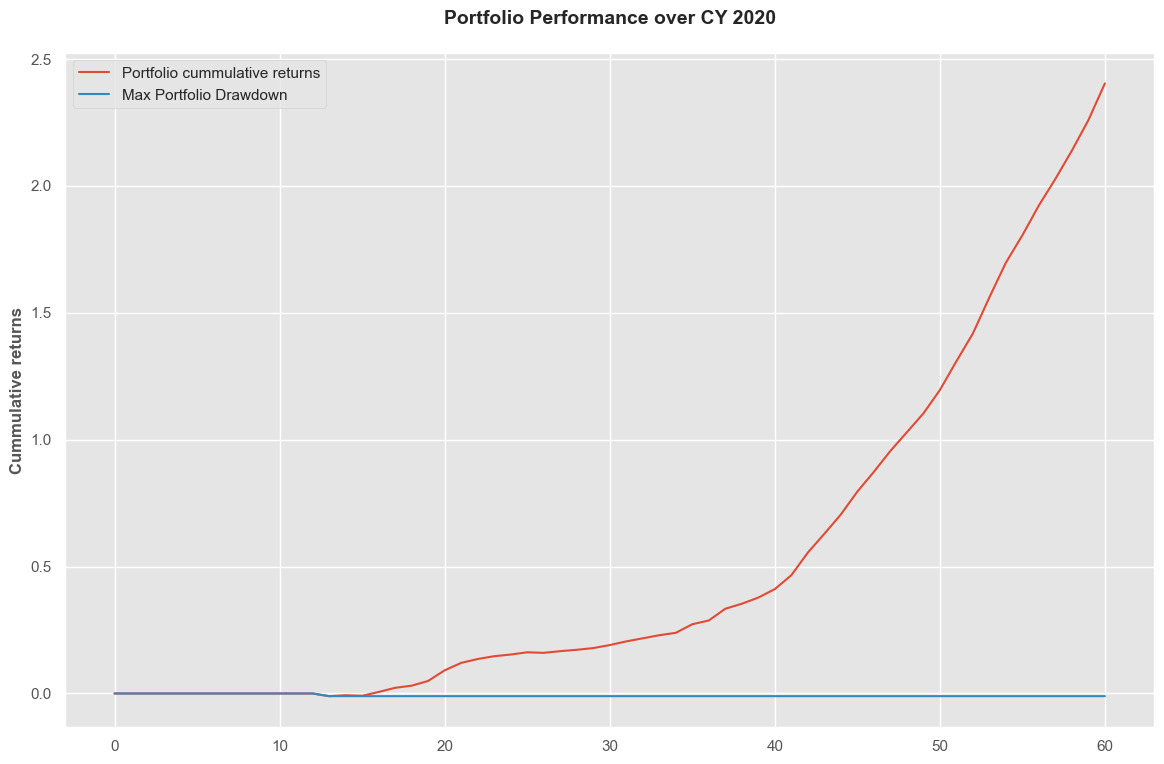

In [199]:
# spy_returns = spy_index_df[spy_index_df.date > dt.datetime(2020, 1, 1)]['cummluative_return']
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=.25, wspace=.25)
plt.clf()
plt.plot(portf_cum_PnL/(capital_per_pair * 9), label='Portfolio cummulative returns')
plt.plot(portf_maxDD/(capital_per_pair * 9), label='Max Portfolio Drawdown')
plt.title(f'Portfolio Performance over CY 2020\n', weight='bold', fontsize=14)
plt.ylabel('Cummulative returns', weight='bold', fontsize=12)
plt.legend()
plt.tight_layout(pad=2.0)
plt.show()

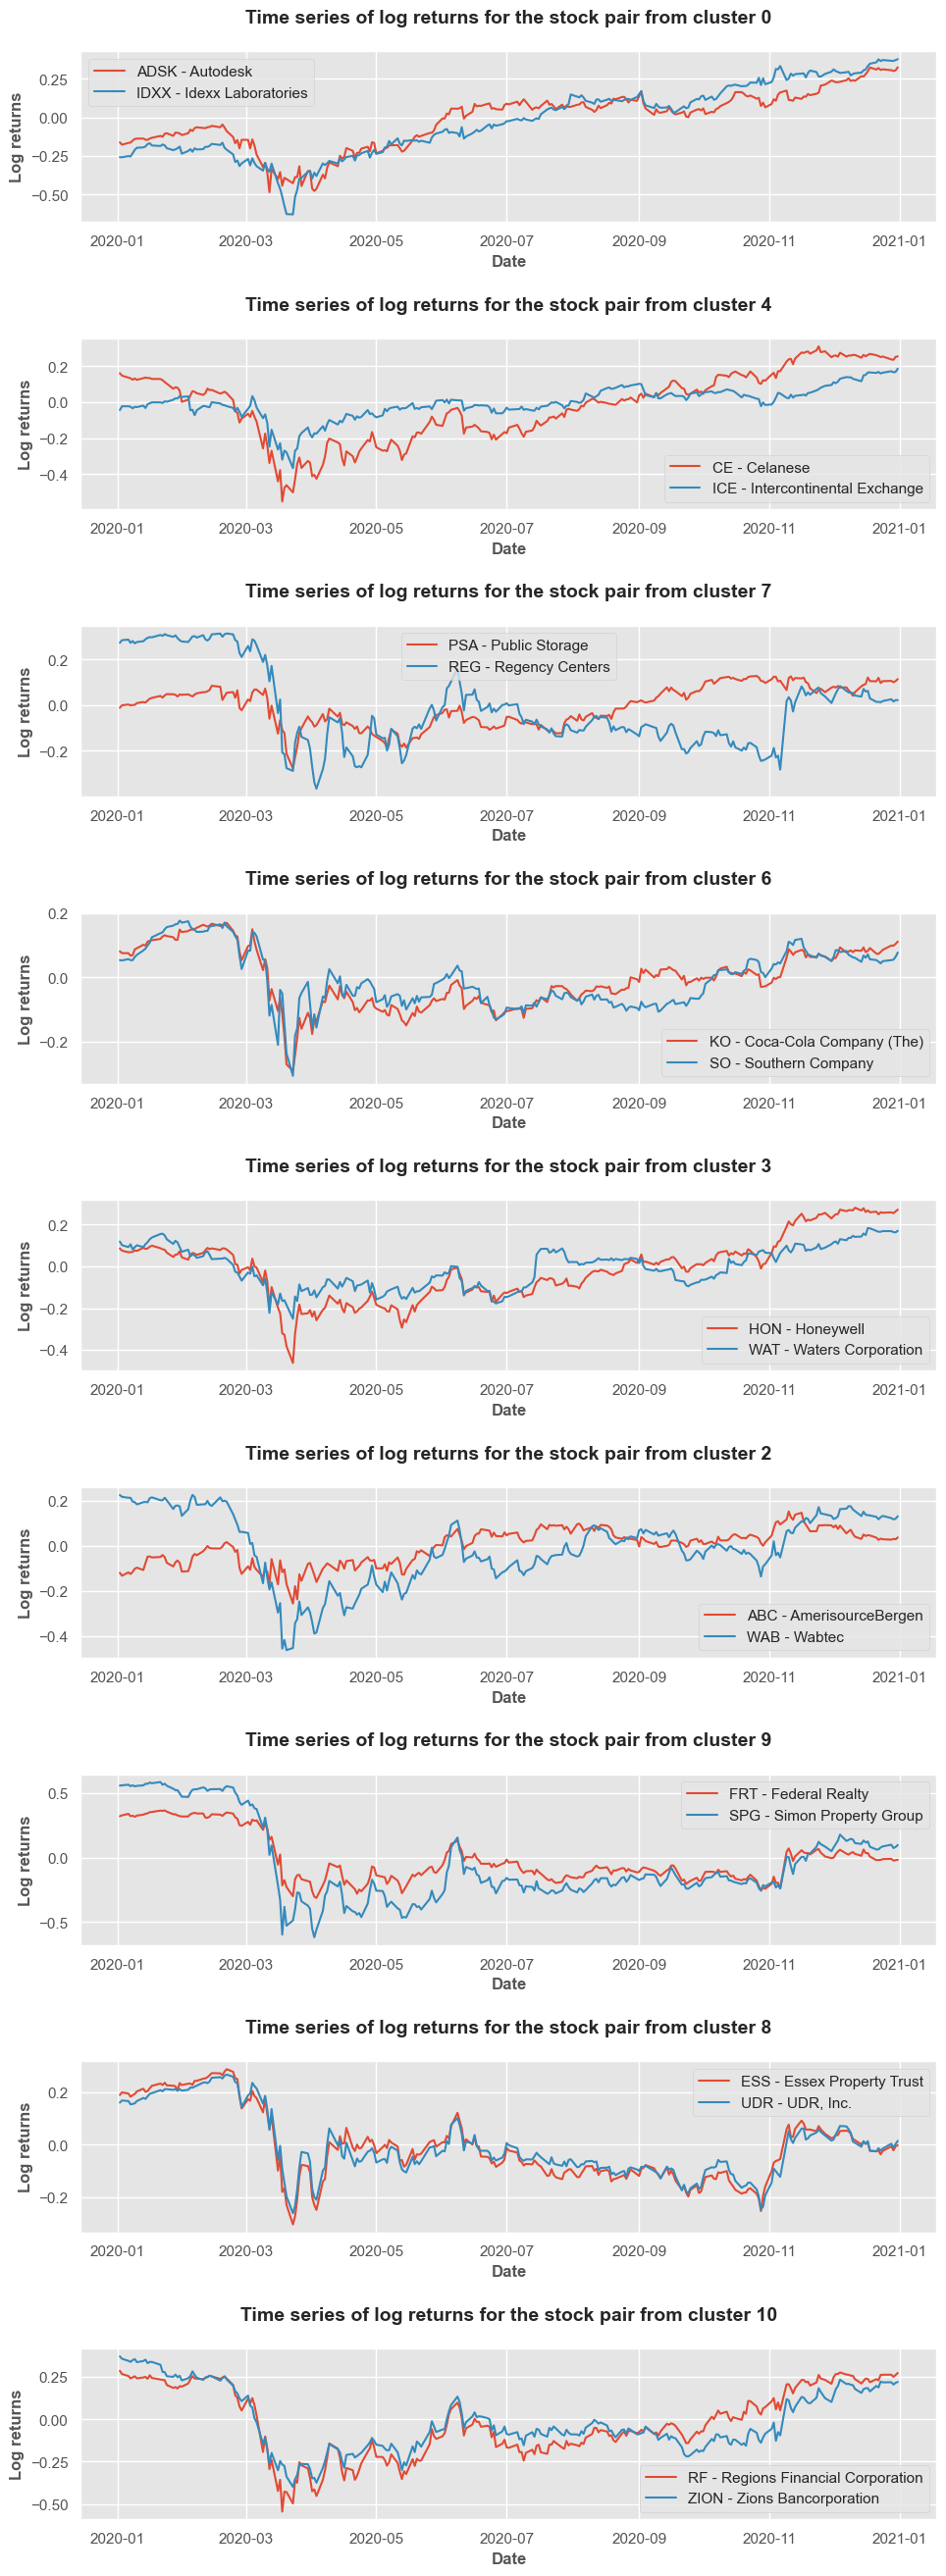

In [195]:
plot_stock_pairs(final_pairs, dt.datetime(2020, 1, 1), dt.datetime(2020, 12, 31))

In [197]:
spy_daily_price = spy_index_df[(spy_index_df.date > dt.datetime(2020, 1, 1)) & (spy_index_df.date < dt.datetime(2020, 12, 31))]['Adj Close']
spy_daily_ret = spy_daily_price.pct_change()
spy_tot_return = ((spy_daily_price.values[-1] - spy_daily_price.values[0]) / spy_daily_price.values[0]) * 100
print(f'Benchmark total return: {spy_tot_return}')
spy_sharpe = np.nanmean(spy_daily_ret)/np.nanstd(spy_daily_ret)
print(f'Benchmark sharpe ratio: {spy_sharpe}')

Benchmark total return: 16.683605350604267
Benchmark sharpe ratio: 0.03982165093369173


In [196]:
print(f'Portfolio total return: {portf_cum_PnL[-1]/(capital_per_pair * 9) * 100}')
portf_sharpe = np.nanmean(portf_daily_PnL)/np.nanstd(portf_daily_PnL)
print(f'Portfolio sharpe ratio: {portf_sharpe}')

Portfolio total returns: 240.250578235689
Portfolio sharpe ratio: 0.8654523536460974
